In [177]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from fbprophet import Prophet
import warnings
warnings.filterwarnings("ignore")

In [2]:
ls

COVID-19-models.ipynb     china-covid19-data.zip    coronavirusdataset/
Covid-19-US.ipynb         coronavirus-in-italy/     covid19-in-usa/
china-covid19-data/       coronavirus-in-italy.zip  covid19-in-usa.zip


In [3]:
cd covid19-in-usa/

/Users/jinbiao.ji/mygithub/MLTSA_JJi/midterm/covid19-in-usa


In [4]:
ls

us_covid19_daily.csv*        us_states_covid19_daily.csv*


In [6]:
c19_all_us = pd.read_csv('us_covid19_daily.csv')

In [7]:
c19_all_us['date'] = pd.to_datetime(c19_all_us['date'], format='%Y%m%d')

In [119]:
c19_all_us.head()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,2020-04-04,112,305755.0,1318052.0,31146,44316.0,76804.0,10414.0,1382.0,1312.0,...,16628,76804.0,3278760,3247614,3247614,9666.0,40813.0,1500748.0,339522.0,1840270.0
1,2020-04-03,56,271988.0,1135356.0,61980,19926.0,35991.0,4686.0,593.0,70.0,...,6962,35991.0,1469324,1407344,1407344,1178.0,3342.0,106707.0,32889.0,139596.0
2,2020-04-02,56,239099.0,1028649.0,62101,17157.0,32649.0,4264.0,541.0,67.0,...,5784,32649.0,1329849,1267748,1267748,1084.0,1507.0,89459.0,28283.0,117742.0
3,2020-04-01,56,210816.0,939190.0,59669,16223.0,31142.0,3837.0,4270.0,71.0,...,4700,31142.0,1209675,1150006,1150006,954.0,4482.0,74989.0,26133.0,101122.0
4,2020-03-31,56,184683.0,864201.0,59518,14236.0,26660.0,3402.0,3644.0,69.0,...,3746,26660.0,1108402,1048884,1048884,807.0,4357.0,79877.0,24153.0,104030.0


In [106]:
new_values = c19_all_us.iloc[0][1:5].values/2

In [143]:
c19_all_us.loc[0,'positiveIncrease']

339522.0

In [148]:
c19_all_us.loc[0,'positiveIncrease']

339522.0

In [149]:
c19_all_us.loc[1,'positiveIncrease']

32889.0

In [118]:
c19_all_us.loc[0,'positive'] = new_values[1]
c19_all_us.loc[0,'negative'] = new_values[2]

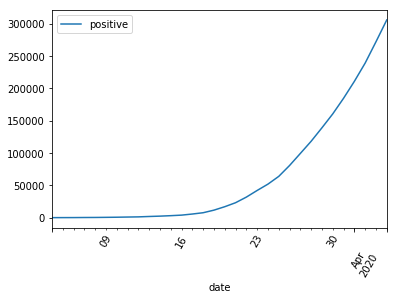

In [121]:
pd.plotting.register_matplotlib_converters()
c19_all_us.plot(x='date',y='positive',rot = 60)

In [175]:
c19_all_us['date'].iloc[-1]

Timestamp('2020-03-04 00:00:00')

### Daily Increase

(18325, 18392)

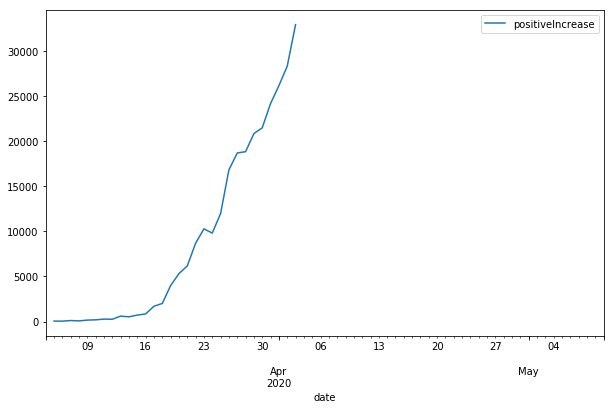

In [176]:
fig,ax=plt.subplots(figsize=(10,6))
c19_all_us[1:].plot(x='date',y='positiveIncrease',ax=ax)
ax.set_xlim(c19_all_us['date'].iloc[-1], pd.Timestamp('2020-05-10'))

# Fit a model to  daily increase? to predict the change point.

### Step 1:

In [14]:
def func_logistic(t, a, b, c):
    return c / (1 + a * np.exp(-b*t))

In [15]:
from scipy.optimize import curve_fit

In [122]:
confirmed_data=c19_all_us[::-1].reset_index().rename(columns={'date':'ds','positive':'y'})
confirmed_data.tail()


,index,ds,states,y,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,...,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
27,4,2020-03-31,56,184683.0,864201.0,59518,14236.0,26660.0,3402.0,3644.0,...,3746,26660.0,1108402,1048884,1048884,807.0,4357.0,79877.0,24153.0,104030.0
28,3,2020-04-01,56,210816.0,939190.0,59669,16223.0,31142.0,3837.0,4270.0,...,4700,31142.0,1209675,1150006,1150006,954.0,4482.0,74989.0,26133.0,101122.0
29,2,2020-04-02,56,239099.0,1028649.0,62101,17157.0,32649.0,4264.0,541.0,...,5784,32649.0,1329849,1267748,1267748,1084.0,1507.0,89459.0,28283.0,117742.0
30,1,2020-04-03,56,271988.0,1135356.0,61980,19926.0,35991.0,4686.0,593.0,...,6962,35991.0,1469324,1407344,1407344,1178.0,3342.0,106707.0,32889.0,139596.0
31,0,2020-04-04,112,305755.0,1318052.0,31146,44316.0,76804.0,10414.0,1382.0,...,16628,76804.0,3278760,3247614,3247614,9666.0,40813.0,1500748.0,339522.0,1840270.0


In [137]:
c19_all_us[::-1]['positive'].values

array([1.18000e+02, 1.76000e+02, 2.23000e+02, 3.41000e+02, 4.17000e+02,
       5.84000e+02, 7.78000e+02, 1.05400e+03, 1.31500e+03, 1.92200e+03,
       2.45000e+03, 3.17300e+03, 4.01900e+03, 5.72200e+03, 7.73000e+03,
       1.17190e+04, 1.70330e+04, 2.31970e+04, 3.18790e+04, 4.21520e+04,
       5.19540e+04, 6.39280e+04, 8.07350e+04, 9.94130e+04, 1.18234e+05,
       1.39061e+05, 1.60530e+05, 1.84683e+05, 2.10816e+05, 2.39099e+05,
       2.71988e+05, 3.05755e+05])

In [138]:
# Randomly initialize the coefficients
p0 = np.random.exponential(size=3)

# Set min bound 0 on all coefficients, and set different max bounds # for each coefficient
bounds = (0, [100000., 1000., 1000000000.])

# Convert pd.Series to np.Array and use Scipy's curve fit to find   # the best Nonlinear Least Squares coefficients
x = np.array(c19_all_us.index.values)+1
y = np.array(c19_all_us[::-1]['positive'].values)

(a,b,c),cov = curve_fit(func_logistic, 
                              x, y, bounds=bounds, p0=p0, maxfev=1000000)
t_fastest = np.log(a) / b
i_fastest = func_logistic(t_fastest, a, b, c)
                

In [139]:
res_df = c19_all_us[1:]['date'].copy()
res_df['fastest_grow_day'] = t_fastest
res_df['fastest_grow_value'] = i_fastest
res_df['growth_stabilized'] = t_fastest <= x[-1]
res_df['timestep'] = x
res_df['res_func_logistic'] = func_logistic(x, a, b, c)


if t_fastest <= x[-1]:
    print('Growth stabilized: South Korea.','| Fastest grow day:', t_fastest, '| Infections:', i_fastest)
    res_df['cap'] = func_logistic(x[-1] + 10, a, b, c)
else:
    print('Growth increasing: South Korea,',  '| Fastest grow day:', t_fastest, '| Infections:', i_fastest)
    res_df['cap'] = func_logistic(i_fastest + 10, a, b, c)

Growth stabilized: South Korea. | Fastest grow day: 29.61312547516455 | Infections: 233350.29788578112


In [140]:
res_df['cap']

445233.62743045343

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 24.
/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



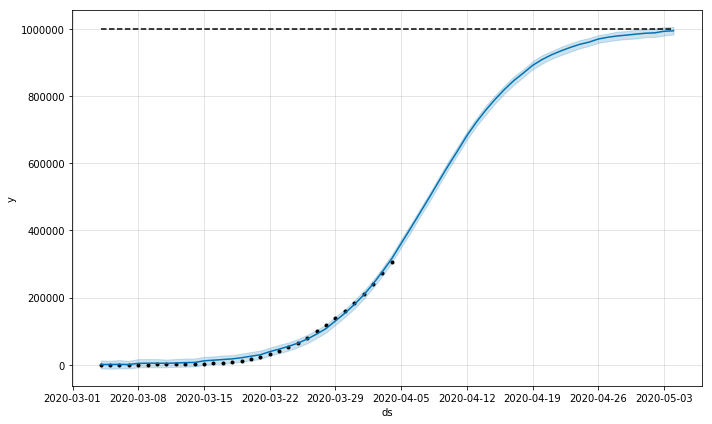

In [130]:
m = Prophet(growth='logistic',interval_width=0.95)
confirmed_data['cap'] = 1000000
m.fit(confirmed_data)
future = m.make_future_dataframe(periods=30)
future['cap'] = 1000000
forecast = m.predict(future)
fig5 = m.plot(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 24.


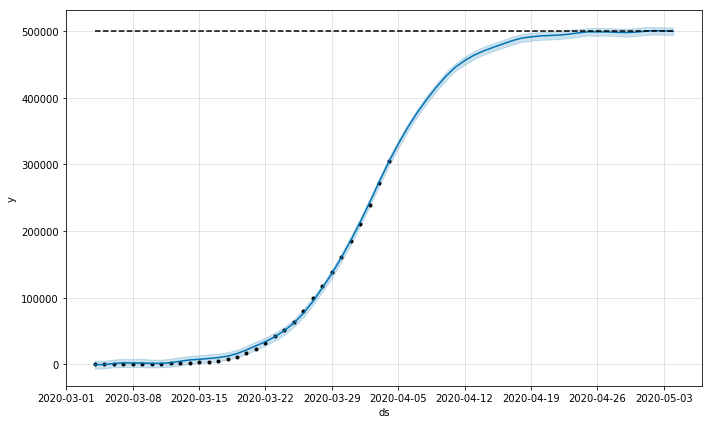

In [180]:
m2 = Prophet(growth='logistic',interval_width=0.95)
confirmed_data['cap'] = 500000
m2.fit(confirmed_data)
future = m2.make_future_dataframe(periods=30)
future['cap'] = 500000
forecast = m2.predict(future)
fig6 = m2.plot(forecast)

In [150]:
from fbprophet import Prophet, diagnostics
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, add_changepoints_to_plot, plot_plotly

In [151]:
def rchi2(y, ytrue):
    return ((y - ytrue)**2).sum() / len(y)

In [179]:
cvresult_m = cross_validation(m, horizon = '2 days')

INFO:fbprophet:Making 23 forecasts with cutoffs between 2020-03-11 00:00:00 and 2020-04-02 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.
INFO:fbprophet:n_changepoints greater than number of observations.Using 8.
INFO:fbprophet:n_changepoints greater than number of observations.Using 9.
INFO:fbprophet:n_changepoints greater than number of observations.Using 10.
INFO:fbprophet:n_changepoints greater than number of observations.Using 11.
INFO:fbprophet:n_changepoints greater than number of observations.Using 11.
INFO:fbprophet:n_changepoints greater than number of observations.Using 12.
INFO:fbprophet:n_changepoints greater than number of observations.Using 13.
INFO:fbprophet:n_changepoints greater than number of observations.Usin

In [157]:
cvresult_m.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
41,2020-04-02,272390.657317,264014.667745,280006.830059,239099.0,2020-03-31
42,2020-04-02,260591.295789,251256.134650,270036.836990,239099.0,2020-04-01
43,2020-04-03,303503.434962,293939.306781,312592.756496,271988.0,2020-04-01
44,2020-04-03,292087.071525,281149.375740,302081.344909,271988.0,2020-04-02
45,2020-04-04,335410.627400,325586.162490,345508.924113,305755.0,2020-04-02


In [155]:
print('Reduced Chi square is {}.'.format(rchi2(cvresult_m.yhat, 
                                               cvresult_m.y)))

Reduced Chi square is 216855992.05798617.


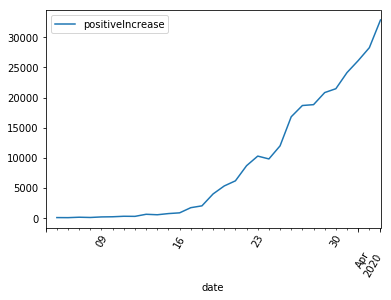

In [142]:
c19_all_us[1:].plot(x='date',y='positiveIncrease',rot = 60)

In [160]:
cvresult_m2 = cross_validation(m2, horizon = '2 days')

INFO:fbprophet:Making 23 forecasts with cutoffs between 2020-03-11 00:00:00 and 2020-04-02 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:n_changepoints greater than number of observations.Using 7.
/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.f